In [31]:
import numpy as np
from typing import List, Optional, Tuple
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

In [2]:
localizations = np.load('logs/localization.npy')

In [3]:
localizations[:5]

array([[ 4.42124252e+06,  4.83017221e+05,  0.00000000e+00],
       [ 4.42124263e+06,  4.83017268e+05,  0.00000000e+00],
       [ 4.42124264e+06,  4.83017249e+05,  0.00000000e+00],
       [ 4.42124261e+06,  4.83017201e+05,  0.00000000e+00],
       [ 4.42124272e+06,  4.83017207e+05, -1.77635684e-15]])

In [ ]:
class Clusterer:
    """
    Online clustering for 3D coordinate points.
    Assigns points to existing clusters or creates new ones based on distance threshold.
    
    notes: This is only for static object for now.
    """
    
    def __init__(self, distance_threshold: float = 1.0, method: str = 'centroid'):
        """
        Initialize the online clusterer.
        
        Args:
            distance_threshold (float): Maximum distance for a point to be considered part of an existing cluster
            method (str):
                'centroid' - compare to cluster centroid
                'nearest' - compare to nearest point in cluster
                'average' - compare to average distance to all points in cluster
        """
        self.distance_threshold = distance_threshold
        self.method = method
        self.clusters = {}
        self.cluster_centroids = {}
        self.next_cluster_id = 0
        
        
    def add_point(self, point: np.ndarray) -> int:
        """
        Add a new point and return its cluster assignment.
        
        Args:
            point (np.ndarray): 3D coordinate point (shape: (3,))
            
        Returns:
            int : cluster ID assigned to this point
        """
        point = np.array(point).reshape(-1)
        
        if len(self.clusters) == 0:
            # First point, create first cluster
            cluster_id = self._create_new_cluster(point)
        else:
            # Find nearest cluster
            cluster_id = self._find_nearest_cluster(point)
            
            if cluster_id is None:
                # No cluster within threshold, create new one
                cluster_id = self._create_new_cluster(point)
            else:
                # Add to existing cluster
                self._add_to_cluster(cluster_id, point)
                
        return cluster_id
    
    
    def add_batch(self, points: np.ndarray) -> List[int]:
        """
        Add multiple points at once.
            
        Args:
            points (np.ndarray): Array of 3D points (shape: (N, 3))
            
        Returns:
            List[int] : cluster IDs for each point
        """
        cluster_ids = []
        for point in points:
            cluster_ids.append(self.add_point(point))
        return cluster_ids
    
    
    def _find_nearest_cluster(self, point: np.ndarray) -> Optional[int]:
        """
        Find the nearest cluster within threshold distance.
        """
        min_distance = float('inf')
        nearest_cluster = None
        
        for cluster_id in self.clusters:
            distance = self._compute_distance_to_cluster(point, cluster_id)
            
            if distance < min_distance and distance <= self.distance_threshold:
                min_distance = distance
                nearest_cluster = cluster_id
                
        return nearest_cluster
    
    def _compute_distance_to_cluster(self, point: np.ndarray, cluster_id: int) -> float:
        """
        Compute distance from point to cluster based on selected method.
        """
        if self.method == 'centroid':
            # Distance to cluster centroid
            return np.linalg.norm(point - self.cluster_centroids[cluster_id])
            
        elif self.method == 'nearest':
            # Distance to nearest point in cluster
            cluster_points = np.array(self.clusters[cluster_id])
            distances = np.linalg.norm(cluster_points - point, axis=1)
            return np.min(distances)
            
        elif self.method == 'average':
            # Average distance to all points in cluster
            cluster_points = np.array(self.clusters[cluster_id])
            distances = np.linalg.norm(cluster_points - point, axis=1)
            return np.mean(distances)
            
        else:
            raise ValueError(f"Unknown method: {self.method}")
    
    def _create_new_cluster(self, point: np.ndarray) -> int:
        """
        Create a new cluster with the given point.
        """
        cluster_id = self.next_cluster_id
        self.next_cluster_id += 1
        
        self.clusters[cluster_id] = [point]
        self.cluster_centroids[cluster_id] = point.copy()
        
        return cluster_id
    
    def _add_to_cluster(self, cluster_id: int, point: np.ndarray):
        """
        Add point to existing cluster and update centroid.
        """
        self.clusters[cluster_id].append(point)
        
        # Update centroid incrementally
        n = len(self.clusters[cluster_id])
        old_centroid = self.cluster_centroids[cluster_id]
        self.cluster_centroids[cluster_id] = (old_centroid * (n-1) + point) / n
    
    def get_cluster_points(self, cluster_id: int) -> np.ndarray:
        """
        Get all points in a specific cluster.
        """
        if cluster_id in self.clusters:
            return np.array(self.clusters[cluster_id])
        else:
            return np.array([])
    
    def get_all_clusters(self) -> dict:
        """
        Get all clusters as a dictionary.
        """
        return {cid: np.array(points) for cid, points in self.clusters.items()}
    
    def get_cluster_info(self) -> dict:
        """
        Get information about all clusters.
        """
        info = {}
        for cluster_id in self.clusters:
            points = np.array(self.clusters[cluster_id])
            info[cluster_id] = {
                'num_points': len(points),
                'centroid': self.cluster_centroids[cluster_id],
                'min': points.min(axis=0),
                'max': points.max(axis=0),
                'std': points.std(axis=0) if len(points) > 1 else np.zeros(3)
            }
        return info
    
    def merge_clusters(self, cluster_id1: int, cluster_id2: int):
        """
        Merge two clusters into one.
        """
        if cluster_id1 not in self.clusters or cluster_id2 not in self.clusters:
            raise ValueError("Invalid cluster IDs")
            
        # Merge points from cluster2 into cluster1
        self.clusters[cluster_id1].extend(self.clusters[cluster_id2])
        
        # Update centroid
        points = np.array(self.clusters[cluster_id1])
        self.cluster_centroids[cluster_id1] = points.mean(axis=0)
        
        # Remove cluster2
        del self.clusters[cluster_id2]
        del self.cluster_centroids[cluster_id2]

In [ ]:
clusterer = Clusterer(distance_threshold=2.5, method='centroid')

In [6]:
for i, detection in enumerate(localizations):
    cluster_id = clusterer.add_point(detection)

In [7]:
cluster_info = clusterer.get_cluster_info()

In [ ]:
clusters = clusterer.get_all_clusters()
colors = plt.cm.Set2(np.linspace(0, 1, len(clusters)))

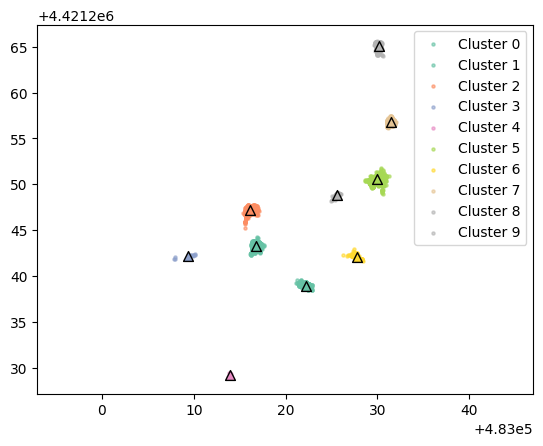

In [29]:
for (cluster_id, points), color in zip(clusters.items(), colors):
    plt.scatter(points[:, 1], points[:, 0], c=[color], s=5, alpha=0.6, label=f'Cluster {cluster_id}')
    
    # Plot centroid
    centroid = clusterer.cluster_centroids[cluster_id]
    plt.scatter(centroid[1], centroid[0], c=[color], s=50, marker='^', edgecolors='black')

plt.axis('equal')
plt.legend()

In [23]:
clusterer2 = OnlineClusterer(distance_threshold= 2.0)

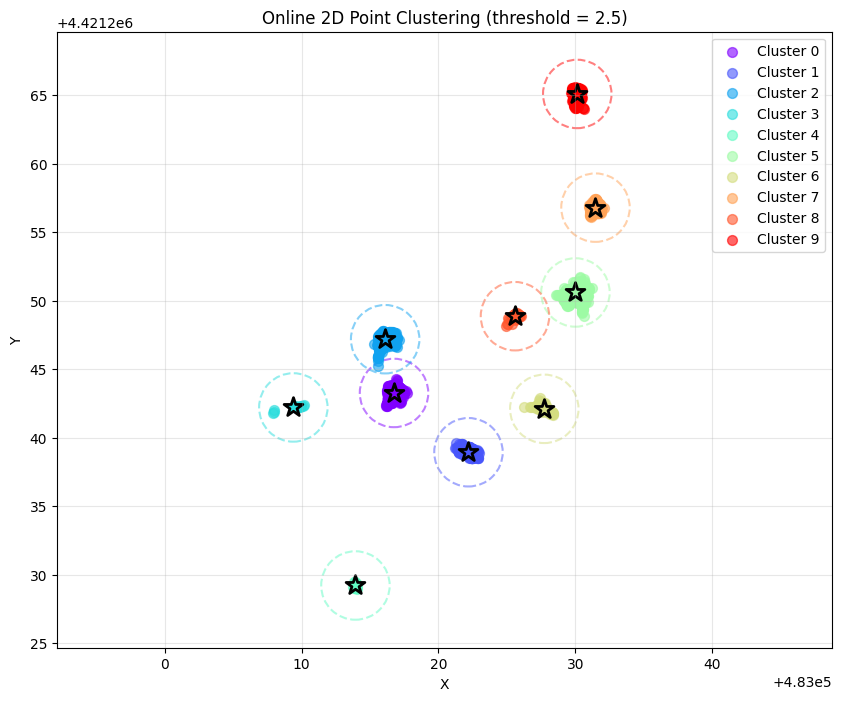

In [35]:
fig, ax = plt.subplots(figsize=(10, 8))
        
clusters = clusterer.get_all_clusters()
colors = plt.cm.rainbow(np.linspace(0, 1, len(clusters)))

for (cluster_id, points), color in zip(clusters.items(), colors):
    # Plot points (only X and Y coordinates)
    ax.scatter(points[:, 1], points[:, 0], 
                c=[color], s=50, alpha=0.6, label=f'Cluster {cluster_id}')
    
    # Plot centroid
    centroid = clusterer.cluster_centroids[cluster_id]
    ax.scatter(centroid[1], centroid[0], 
                c=[color], s=200, marker='*', edgecolors='black', linewidth=2)
    
    # Draw circle showing distance threshold around centroid
    circle = Circle((centroid[1], centroid[0]), 
                    clusterer.distance_threshold, 
                    fill=False, 
                    edgecolor=color, 
                    linestyle='--', 
                    linewidth=1.5, 
                    alpha=0.5)
    ax.add_patch(circle)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title(f'Online 2D Point Clustering (threshold = {clusterer.distance_threshold})')
ax.axis('equal')  # Equal aspect ratio for proper circle visualization
ax.grid(True, alpha=0.3)
ax.legend()